# San Francisco Crime

## Leo CSV como RDD

In [4]:
# usamos pyspark_csv de https://github.com/seahboonsiew/pyspark-csv
# ver README.md

sc.addPyFile('/vagrant/lib/pyspark_csv.py')

import pyspark_csv as pycsv

plaintext_rdd = sc.textFile('/vagrant/sf/train.csv')
dataframe = pycsv.csvToDataFrame(sqlCtx, plaintext_rdd, parseDate=False)

In [5]:
data = dataframe.rdd

## Primer registro de los datos

In [6]:
data.first()

Row(Dates=u'2015-05-13 23:53:00', Category=u'WARRANTS', Descript=u'WARRANT ARREST', DayOfWeek=u'Wednesday', PdDistrict=u'NORTHERN', Resolution=u'ARREST, BOOKED', Address=u'OAK ST / LAGUNA ST', X=-122.425891675136, Y=37.7745985956747)

## Categorías de crímenes

In [7]:
categories = data.map(lambda row: row[1]).distinct()

In [7]:
categories.collect()

[u'WEAPON LAWS',
 u'TREA',
 u'EMBEZZLEMENT',
 u'DRIVING UNDER THE INFLUENCE',
 u'BURGLARY',
 u'LIQUOR LAWS',
 u'MISSING PERSON',
 u'SEX OFFENSES NON FORCIBLE',
 u'EXTORTION',
 u'TRESPASS',
 u'LARCENY/THEFT',
 u'NON-CRIMINAL',
 u'GAMBLING',
 u'OTHER OFFENSES',
 u'DRUNKENNESS',
 u'VEHICLE THEFT',
 u'RECOVERED VEHICLE',
 u'FAMILY OFFENSES',
 u'WARRANTS',
 u'ASSAULT',
 u'BAD CHECKS',
 u'SEX OFFENSES FORCIBLE',
 u'PORNOGRAPHY/OBSCENE MAT',
 u'PROSTITUTION',
 u'BRIBERY',
 u'LOITERING',
 u'ROBBERY',
 u'ARSON',
 u'RUNAWAY',
 u'SUSPICIOUS OCC',
 u'VANDALISM',
 u'KIDNAPPING',
 u'DISORDERLY CONDUCT',
 u'SECONDARY CODES',
 u'STOLEN PROPERTY',
 u'FORGERY/COUNTERFEITING',
 u'FRAUD',
 u'DRUG/NARCOTIC',
 u'SUICIDE']

## Cantidad de categorías de crímenes

In [8]:
categories.count()

39

## Categorías de crímenes ordenadas alfabeticamente

In [9]:
categories.takeOrdered(40)

[u'ARSON',
 u'ASSAULT',
 u'BAD CHECKS',
 u'BRIBERY',
 u'BURGLARY',
 u'DISORDERLY CONDUCT',
 u'DRIVING UNDER THE INFLUENCE',
 u'DRUG/NARCOTIC',
 u'DRUNKENNESS',
 u'EMBEZZLEMENT',
 u'EXTORTION',
 u'FAMILY OFFENSES',
 u'FORGERY/COUNTERFEITING',
 u'FRAUD',
 u'GAMBLING',
 u'KIDNAPPING',
 u'LARCENY/THEFT',
 u'LIQUOR LAWS',
 u'LOITERING',
 u'MISSING PERSON',
 u'NON-CRIMINAL',
 u'OTHER OFFENSES',
 u'PORNOGRAPHY/OBSCENE MAT',
 u'PROSTITUTION',
 u'RECOVERED VEHICLE',
 u'ROBBERY',
 u'RUNAWAY',
 u'SECONDARY CODES',
 u'SEX OFFENSES FORCIBLE',
 u'SEX OFFENSES NON FORCIBLE',
 u'STOLEN PROPERTY',
 u'SUICIDE',
 u'SUSPICIOUS OCC',
 u'TREA',
 u'TRESPASS',
 u'VANDALISM',
 u'VEHICLE THEFT',
 u'WARRANTS',
 u'WEAPON LAWS']

## 10 delitos más comunes

In [10]:
data.map(lambda row: (row.Category, 1)).reduceByKey(lambda a, b: a+b).takeOrdered(10, key = lambda x: -x[1])

[(u'LARCENY/THEFT', 174900),
 (u'OTHER OFFENSES', 126182),
 (u'NON-CRIMINAL', 92304),
 (u'ASSAULT', 76876),
 (u'DRUG/NARCOTIC', 53971),
 (u'VEHICLE THEFT', 53781),
 (u'VANDALISM', 44725),
 (u'WARRANTS', 42214),
 (u'BURGLARY', 36755),
 (u'SUSPICIOUS OCC', 31414)]

## Día de la semana con más casos de 'Driving under the influence'

In [11]:
data.filter(lambda row: row.Category == 'DRIVING UNDER THE INFLUENCE').map(lambda row: (row.DayOfWeek, 1)).reduceByKey(lambda a, b: a+b).takeOrdered(1, key = lambda x: -x[1])

[(u'Saturday', 457)]

## Los 3 distritos con mayor cantidad de crímenes

In [12]:
data.map(lambda row: (row.PdDistrict, 1)).reduceByKey(lambda a, b: a+b).takeOrdered(3, key = lambda x: -x[1])

[(u'SOUTHERN', 157182), (u'MISSION', 119908), (u'NORTHERN', 105296)]

## Crímenes que tienen mayor porcentaje de resolución “Not Prosecuted”

In [13]:
not_prosecuted = data.filter(lambda row: row.Resolution == 'NOT PROSECUTED').map(lambda row: (row.Category, 1)).reduceByKey(lambda a, b: a+b)

In [14]:
all_resolutions = data.map(lambda row: (row.Category, 1)).reduceByKey(lambda a, b: a+b)

In [15]:
all_resolutions.join(not_prosecuted).takeOrdered(5, key = lambda x: -(x[1][1]*100/x[1][0]))

[(u'FORGERY/COUNTERFEITING', (10609, 698)),
 (u'FRAUD', (16679, 946)),
 (u'BAD CHECKS', (406, 19)),
 (u'GAMBLING', (146, 4)),
 (u'EMBEZZLEMENT', (1166, 21))]

## Delitos por día de la semana

In [16]:
day_of_week_crimes_rdd = data.map(lambda row: (row.DayOfWeek, 1)).reduceByKey(lambda a, b: a+b)

In [17]:
day_of_week_crimes = day_of_week_crimes_rdd.collect()
day_of_week_crimes

[(u'Wednesday', 129211),
 (u'Saturday', 126810),
 (u'Sunday', 116707),
 (u'Tuesday', 124965),
 (u'Thursday', 125038),
 (u'Monday', 121584),
 (u'Friday', 133734)]

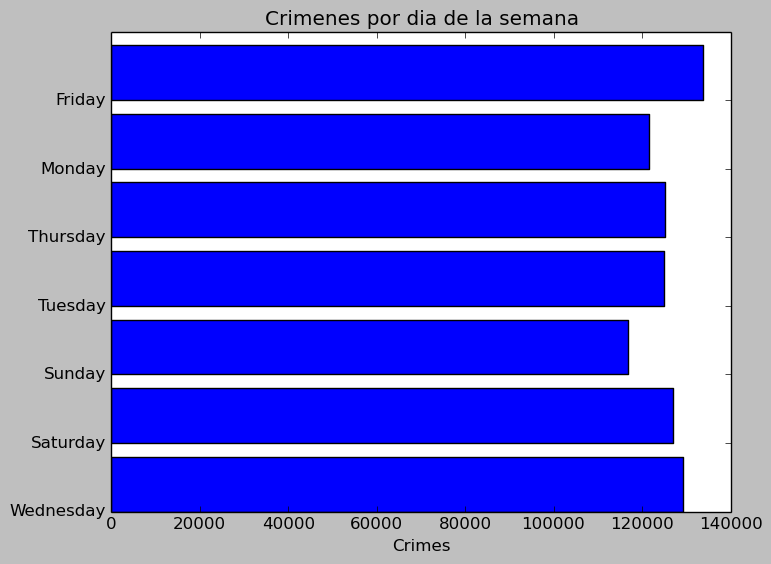

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

days = [t[0] for t in day_of_week_crimes]
y_pos = np.arange(len(days))
crimes = [t[1] for t in day_of_week_crimes]

plt.barh(y_pos, crimes)
plt.yticks(y_pos, days)
plt.xlabel('Crimes')
plt.title('Crimenes por dia de la semana')

plt.show()

In [19]:
dataframe.registerTempTable("crimes")
sqlCtx.sql("select distinct Category from crimes").collect()

[Row(Category=u'ASSAULT'),
 Row(Category=u'MISSING PERSON'),
 Row(Category=u'TREA'),
 Row(Category=u'TRESPASS'),
 Row(Category=u'VANDALISM'),
 Row(Category=u'RECOVERED VEHICLE'),
 Row(Category=u'SEX OFFENSES FORCIBLE'),
 Row(Category=u'BURGLARY'),
 Row(Category=u'DISORDERLY CONDUCT'),
 Row(Category=u'DRUNKENNESS'),
 Row(Category=u'DRIVING UNDER THE INFLUENCE'),
 Row(Category=u'WARRANTS'),
 Row(Category=u'ROBBERY'),
 Row(Category=u'KIDNAPPING'),
 Row(Category=u'SEX OFFENSES NON FORCIBLE'),
 Row(Category=u'FAMILY OFFENSES'),
 Row(Category=u'GAMBLING'),
 Row(Category=u'OTHER OFFENSES'),
 Row(Category=u'PORNOGRAPHY/OBSCENE MAT'),
 Row(Category=u'FRAUD'),
 Row(Category=u'EXTORTION'),
 Row(Category=u'RUNAWAY'),
 Row(Category=u'FORGERY/COUNTERFEITING'),
 Row(Category=u'PROSTITUTION'),
 Row(Category=u'LARCENY/THEFT'),
 Row(Category=u'EMBEZZLEMENT'),
 Row(Category=u'VEHICLE THEFT'),
 Row(Category=u'BRIBERY'),
 Row(Category=u'WEAPON LAWS'),
 Row(Category=u'LIQUOR LAWS'),
 Row(Category=u'STOLEN P

In [20]:
sqlCtx.sql("select distinct Category from crimes order by Category").collect()

[Row(Category=u'ARSON'),
 Row(Category=u'ASSAULT'),
 Row(Category=u'BAD CHECKS'),
 Row(Category=u'BRIBERY'),
 Row(Category=u'BURGLARY'),
 Row(Category=u'DISORDERLY CONDUCT'),
 Row(Category=u'DRIVING UNDER THE INFLUENCE'),
 Row(Category=u'DRUG/NARCOTIC'),
 Row(Category=u'DRUNKENNESS'),
 Row(Category=u'EMBEZZLEMENT'),
 Row(Category=u'EXTORTION'),
 Row(Category=u'FAMILY OFFENSES'),
 Row(Category=u'FORGERY/COUNTERFEITING'),
 Row(Category=u'FRAUD'),
 Row(Category=u'GAMBLING'),
 Row(Category=u'KIDNAPPING'),
 Row(Category=u'LARCENY/THEFT'),
 Row(Category=u'LIQUOR LAWS'),
 Row(Category=u'LOITERING'),
 Row(Category=u'MISSING PERSON'),
 Row(Category=u'NON-CRIMINAL'),
 Row(Category=u'OTHER OFFENSES'),
 Row(Category=u'PORNOGRAPHY/OBSCENE MAT'),
 Row(Category=u'PROSTITUTION'),
 Row(Category=u'RECOVERED VEHICLE'),
 Row(Category=u'ROBBERY'),
 Row(Category=u'RUNAWAY'),
 Row(Category=u'SECONDARY CODES'),
 Row(Category=u'SEX OFFENSES FORCIBLE'),
 Row(Category=u'SEX OFFENSES NON FORCIBLE'),
 Row(Category

## 10 delitos más comunes con SQL

In [21]:
sqlCtx.sql("select Category, count(*) as crimes_count from crimes group by Category order by crimes_count desc limit 10").collect()

[Row(Category=u'LARCENY/THEFT', crimes_count=174900),
 Row(Category=u'OTHER OFFENSES', crimes_count=126182),
 Row(Category=u'NON-CRIMINAL', crimes_count=92304),
 Row(Category=u'ASSAULT', crimes_count=76876),
 Row(Category=u'DRUG/NARCOTIC', crimes_count=53971),
 Row(Category=u'VEHICLE THEFT', crimes_count=53781),
 Row(Category=u'VANDALISM', crimes_count=44725),
 Row(Category=u'WARRANTS', crimes_count=42214),
 Row(Category=u'BURGLARY', crimes_count=36755),
 Row(Category=u'SUSPICIOUS OCC', crimes_count=31414)]

## Día de la semana con más casos de 'Driving under the influence'

In [22]:
sqlCtx.sql("select DayOfWeek, count(*) as crimes_count from crimes where Category == 'DRIVING UNDER THE INFLUENCE' group by DayOfWeek order by crimes_count desc limit 1").collect()

[Row(DayOfWeek=u'Saturday', crimes_count=457)]